# **Visualisations and further analysis**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Results CSV from CNN

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Import Libraries

In [46]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr
from sklearn.metrics import confusion_matrix
from scipy.stats import chisquare

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:

current_dir = os.getcwd()
current_dir

'c:\\Users\\Eddie\\Documents\\CodeInstitute Workspace\\Capstone Project\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
if os.path.basename(current_dir).lower() == "jupyter_notebooks":
    os.chdir(os.path.dirname(current_dir))
    print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Eddie\\Documents\\CodeInstitute Workspace\\Capstone Project'

# Import Data

Load results CSV

In [5]:
df = pd.read_csv("./Data/Processed/results.csv")
df.head()

,True,ResizedPred,PaddedPred,GreyPred,LuminanceResized,LuminancePadded,ContrastResized,ContrastPadded
0,3,3,3,3,92.250798,92.250798,67.670746,67.670746
1,4,0,1,3,205.441659,205.441659,54.976438,54.976438
2,1,1,1,1,183.920559,183.920559,58.935398,58.935398
3,0,0,0,3,162.564613,162.564613,63.786797,63.786797
4,3,3,3,0,146.125790,146.125790,70.926940,70.926940


---

# Statistical Analysis

Does higher contrast mean an easier classification?

Does luminance not have an impact on classification?

In [6]:
df['Correct']=(df['True'] == df['ResizedPred'])
df.head()

,True,ResizedPred,PaddedPred,GreyPred,LuminanceResized,LuminancePadded,ContrastResized,ContrastPadded,Correct
0,3,3,3,3,92.250798,92.250798,67.670746,67.670746,True
1,4,0,1,3,205.441659,205.441659,54.976438,54.976438,False
2,1,1,1,1,183.920559,183.920559,58.935398,58.935398,True
3,0,0,0,3,162.564613,162.564613,63.786797,63.786797,True
4,3,3,3,0,146.125790,146.125790,70.926940,70.926940,True


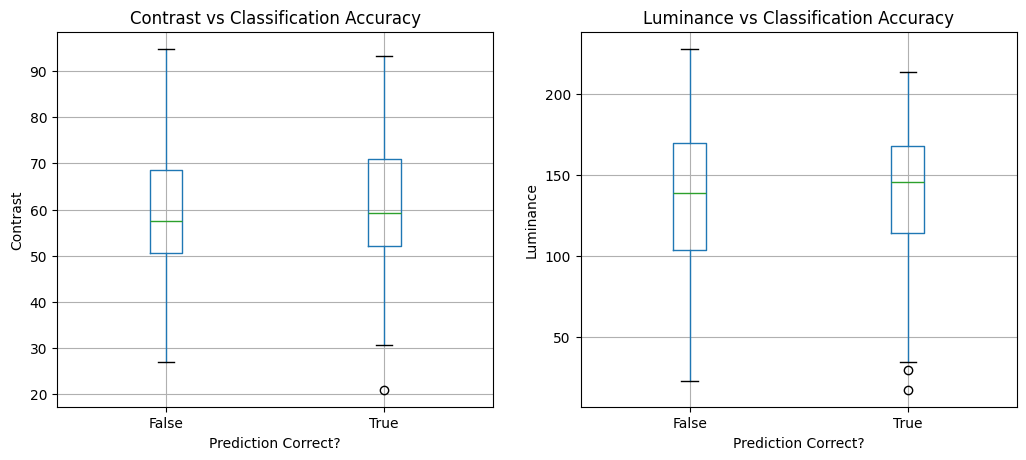

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

df.boxplot(column='ContrastResized', by='Correct', ax=ax1)
ax1.set_title("Contrast vs Classification Accuracy")
ax1.set_ylabel("Contrast")
ax1.set_xlabel("Prediction Correct?")

df.boxplot(column='LuminanceResized', by='Correct', ax=ax2)
ax2.set_title("Luminance vs Classification Accuracy")
ax2.set_ylabel("Luminance")
ax2.set_xlabel("Prediction Correct?")

plt.suptitle("")  # remove automatic title
plt.show()

In [22]:
#point biserial correlation used for one binary and one continuous variable

corr, p_value = pointbiserialr(df['ContrastResized'], df['Correct'])
print("Correlation:", corr)
print("p-value:", p_value)

corr, p_value = pointbiserialr(df['LuminanceResized'], df['Correct'])
print("Correlation:", corr)
print("p-value:", p_value)

Correlation: 0.061610053218418795
p-value: 0.2779600028109102
Correlation: 0.02253449320775202
p-value: 0.691742689524333


Result: Not statistically significant

---

The dataset contains 5 negative emotions (anger, disgust, fear, pain, sad) and 1 positive emotion (happy)

Do misclassifications of the negative emotions tend to be skewed towards the other negative emotions?

Observed Counts: [127  61]
Expected Counts: [156.66666666666666, 31.333333333333332]
Chi-Square Statistic: 33.706382978723404
p-value: 6.4090046657038655e-09


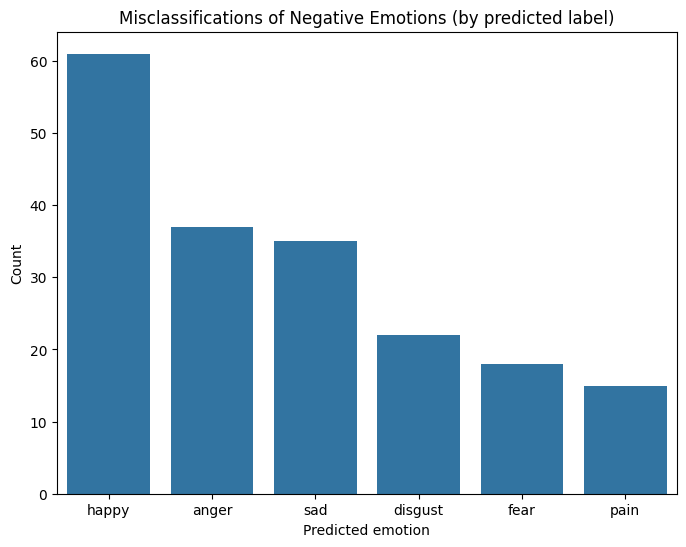

In [52]:
# define class names in encoder order (edit if your order differs)
label_names = ['anger', 'disgust', 'fear', 'happy', 'pain', 'sad']

# safe copy of misclassified rows
df_misclassified = df.loc[~df['Correct']].copy()

# map encoded ints -> names
label_map = {i: name for i, name in enumerate(label_names)}
df_misclassified.loc[:, 'TrueName'] = df_misclassified['True'].map(label_map)
df_misclassified.loc[:, 'ResizedPredName'] = df_misclassified['ResizedPred'].map(label_map)

# create POS/NEG groups safely
positive_emotion = 3  # index of 'happy' in label_names
df_misclassified.loc[:, 'TrueGroup'] = np.where(df_misclassified['True'] == positive_emotion, 'POS', 'NEG')
df_misclassified.loc[:, 'PredGroup'] = np.where(df_misclassified['ResizedPred'] == positive_emotion, 'POS', 'NEG')

# Chi-Square Goodness of Fit (as before)
total_misclassified = len(df_misclassified)
observed_counts = df_misclassified['PredGroup'].value_counts().reindex(['NEG', 'POS'], fill_value=0).values
expected_counts = [total_misclassified * 5/6, total_misclassified * 1/6]

print("Observed Counts:", observed_counts)
print("Expected Counts:", expected_counts)

chi2, p = chisquare(observed_counts, f_exp=expected_counts)
print("Chi-Square Statistic:", chi2)
print("p-value:", p)

# plot misclassification counts using label names
plt.figure(figsize=(8,6))
order = df_misclassified['ResizedPredName'].value_counts().index
sns.countplot(data=df_misclassified, x='ResizedPredName', order=order)
plt.title("Misclassifications of Negative Emotions (by predicted label)")
plt.xlabel("Predicted emotion")
plt.ylabel("Count")
plt.show()

p<0.05 -> Misclassification as positive is statistically significant. Hypothesis is false

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create your folder here
  # os.makedirs(name='')
except Exception as e:
  print(e)
